# 2.Mnist Images Classifier

In [1]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random
import struct
from array import array
from scipy.linalg import svd

#### Minst data loader class and view functions

In [2]:
# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text != '':
            plt.title(title_text, fontsize=15)
        index += 1


def show_imported_data(x_train, x_test, y_train, y_test):
    #
    # Show some random training and test images
    #
    images_2_show = []
    titles_2_show = []
    for i in range(0, 10):
        r = random.randint(1, 60000)
        images_2_show.append(x_train[r])
        titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

    for i in range(0, 5):
        r = random.randint(1, 10000)
        images_2_show.append(x_test[r])
        titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

    show_images(images_2_show, titles_2_show)
    plt.show()


def read_images_labels(images_filepath, labels_filepath):
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img

    return images, labels


#
# MNIST Data Loader Class
#
class MnistDataLoader(object):
    def __init__(self, _training_images_filepath, _training_labels_filepath,
                 _test_images_filepath, _test_labels_filepath):
        self.training_images_filepath = _training_images_filepath
        self.training_labels_filepath = _training_labels_filepath
        self.test_images_filepath = _test_images_filepath
        self.test_labels_filepath = _test_labels_filepath

    def load_data(self):
        _x_train, _y_train = read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        _x_test, _y_test = read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (_x_train, _y_train), (_x_test, _y_test)


###### loading the data into x_train, y_train, x_test and y_test

In [3]:
# Set file paths based on added MNIST Datasets
input_path = r'data'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#v
# Load MINST dataset
#
# loading data into x_train variable
mnist_data_loader = MnistDataLoader(training_images_filepath, training_labels_filepath, test_images_filepath,
                                    test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_data_loader.load_data()
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## sections a-b
#### PCA class and helper functions


In [4]:
class PCA:
    def __init__(self):
        self.x = None
        self.cov = None
        self.u_tp = None
        self.m = None
        self.n = None

    def reduce_dimension(self, data, p):
        # x.shape = (n, m)
        self.x = data
        self.n, self.m = self.x.shape

        # cov.shape = (n, n)
        self._compute_covariance_matrix()

        # eigen decomposition of cov
        u, s, v = svd(self.cov)

        # we have n singular values in decaying order
        self.u_tp = u[:, 0:p].T
        # u_t.shape = (n, n)
        # sorted eigen vectors in rows
        # self._get_u_t()


        # w.shape = (p, m)
        w = self.u_tp @ self.x

        # returns sigma and self.u_tp for plotting purposes and w as the reduced data
        return s, w, self.u_tp

    def _compute_covariance_matrix(self):
        self.cov = self.x @ self.x.T / self.m

def prepare_images_for_pca(images_data):
    images_data = ((np.array(images_data) / 255) - 0.5)
    m, n, k = np.shape(images_data)
    x = np.zeros((n * k, m))
    for i in range(m):
        row = images_data[i].flatten()
        column = row.T
        np.copyto(x[:, i], column)
    return x

def reconstruct_images(_images, size):
    shape = [_images.shape[1]]
    for num in size:
        shape.append(num)
    _new_images = np.empty(shape)
    for i in range(shape[0]):
        image = np.reshape(_images[:, i], size)
        np.copyto(_new_images[i], image)
    return _new_images

def plot_examples(_sigma, old_img_data, new_img_data):
    plt.plot(_sigma)
    plt.title("Singular Values")
    plt.xlabel('frequency')
    plt.ylabel('values')
    plt.legend("singular values")
    _images = [old_img_data, new_img_data]
    labels = ["original image", "new image"]
    show_images(_images, labels)
    plt.show()

##### creating x(images) matrix for, then preforming pca dimension reduction on x

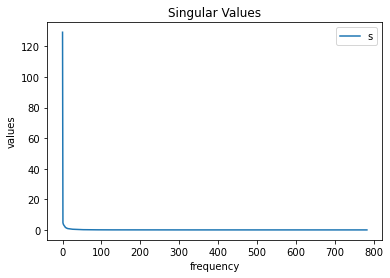

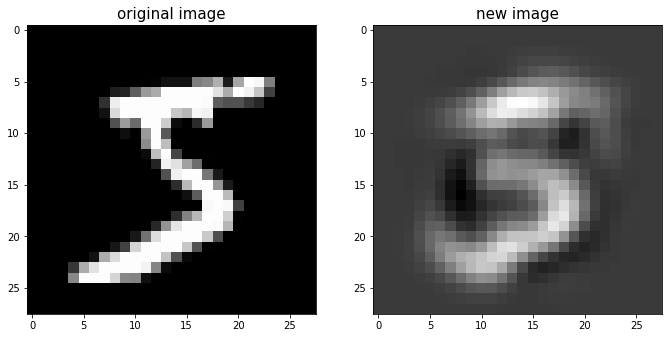

In [5]:
# "normalize the data"
images = prepare_images_for_pca(x_train.copy())
# x_train.shape = (60000, 28, 28), images.shape = (784, 60000)

pca = PCA()
sigma, reduced_data, u_tp = pca.reduce_dimension(images, 20)

# new_images_columns = (784, 60000)
new_images_columns = u_tp.T @ reduced_data

#  reconstructing the images back to a pixel.
new_images = reconstruct_images(new_images_columns, (28, 28))

# plots for sections b
plot_examples(sigma, x_train[0], new_images[0])

## section c
#### KMeans class and distance function

In [6]:
def distance(vector1, vector2):
    return np.linalg.norm(vector1-vector2)


class KMeans:
    def __init__(self, k=10, max_iterations=300):
        self.k = k
        self.max_iterations = max_iterations
        self.centers = []
        self.clusters = None
        self.labels = None
        self.data = None
        self.num_of_samples = None
        self.num_of_dimensions = None

    def find_clusters(self, data, start_centers=None):
        self.data = data.T
        self.num_of_samples, self.num_of_dimensions = self.data.shape

        if start_centers is None:
            # random starting centers
            random_image_indexes = np.random.choice(self.num_of_samples, self.k, replace=False)
            self.centers = [self.data[idx] for idx in random_image_indexes]
        else:
            self.centers = start_centers

        # algorithm loop
        for it in range(self.max_iterations):
            # Assignment step
            self._calculate_clusters()

            # Update step
            old_centers = self.centers
            self._calculate_centers()

            # check if the centers changed
            if self._compare(old_centers):
                break

        return self.centers, self.clusters

    def _calculate_clusters(self):
        # empty all cluster lists
        _clusters = [[] for _ in range(self.k)]

        # assign images to clusters according to centers
        for i, xi in enumerate(self.data):
            distances = [distance(xi, center) for center in self.centers]
            center_index = np.argmin(distances)
            _clusters[center_index].append(i)
        self.clusters = _clusters

    def _calculate_centers(self):
        # assign mean value of clusters to centers
        _centers = np.zeros((self.k, self.num_of_dimensions))
        for j, cluster in enumerate(self.clusters):
            cluster_center = np.mean(self.data[cluster], axis=0)
            _centers[j] = cluster_center
        self.centers = _centers

    def _compare(self, old_centers):
        # if a center didn't change the distance should be 0,
        # therefore if the sum of all distances is 0 the centers didn't change
        distances = [distance(old_centers[i], self.centers[i]) for i in range(self.k)]
        return sum(distances) == 0

## sections d-e
##### performing kmeans on reduced_data of the images

In [7]:
kmeans = KMeans()

def show_kmeans_results(_centers, _clusters, labels,  _u_tp, plot):
    # label clusters
    _clusters_labels = []
    for cluster in _clusters:
        cluster_labels = [labels[i] for i in cluster]
        cluster_counter = Counter(cluster_labels)
        _clusters_labels.append(cluster_counter.most_common(1)[0][0])

    if plot:
        centers_labels = [f"Cluster label: {label}" for label in _clusters_labels]
        # centers.shape = (p, k)
        _centers = np.asarray(_centers).T
        # centers_as_images.shape = (m * n, k)
        centers_as_images = _u_tp.T @ _centers
        centers_as_images = reconstruct_images(centers_as_images, (28, 28))
        show_images(centers_as_images, centers_labels)
        plt.show()
    return _clusters_labels

def test_results(test_data, test_labels, _centers, centers_labels, utp):
    num_of_samples = np.shape(test_data)[0]
    success_counter = num_of_samples
    x = prepare_images_for_pca(test_data)
    for index, image in enumerate((utp @ x).T):
        distances = [distance(image, center) for center in _centers]
        closest = np.argmin(distances)
        if test_labels[index] != centers_labels[closest]:
            success_counter = success_counter - 1
    return (success_counter / num_of_samples) * 100

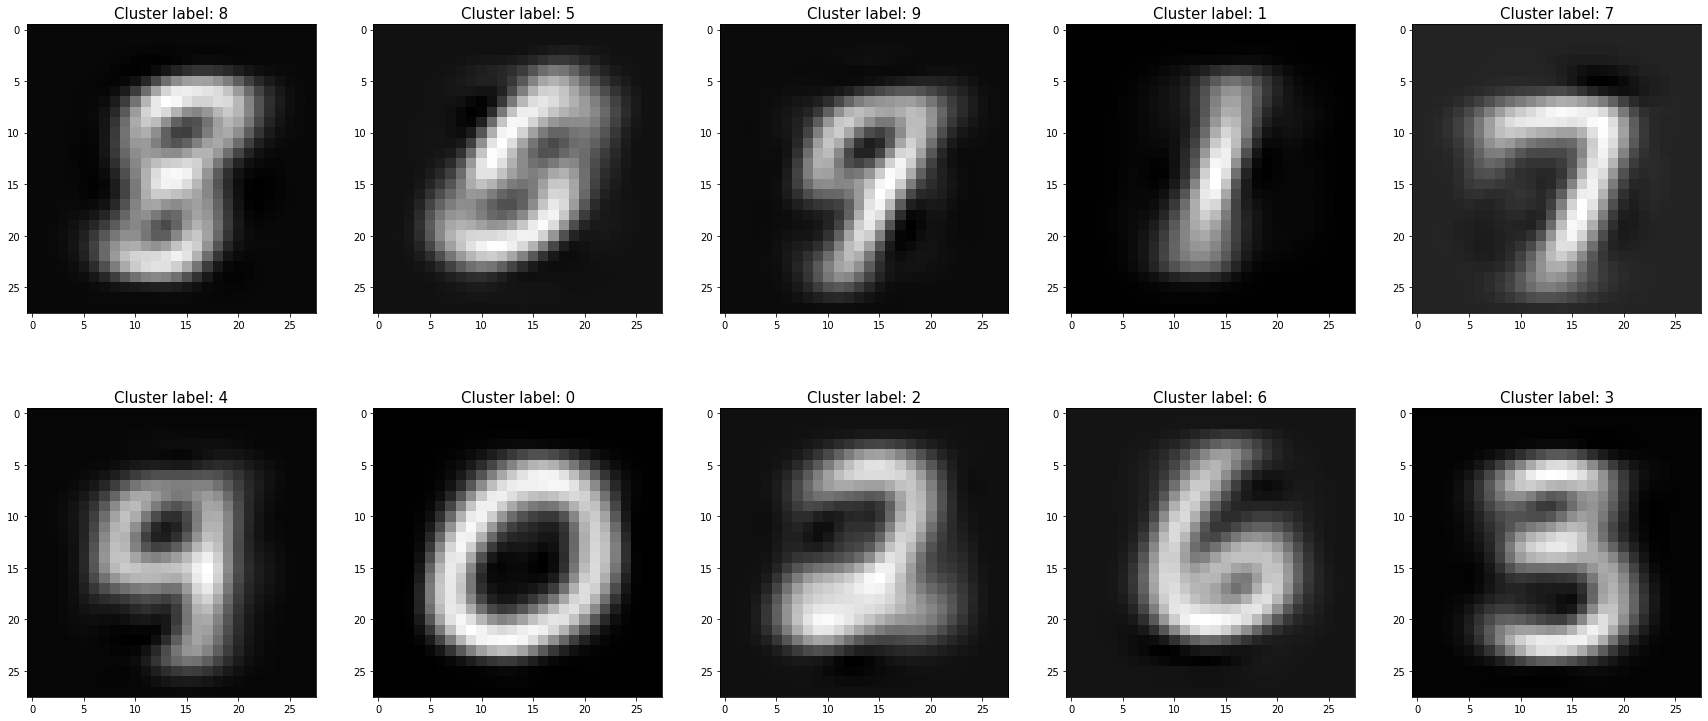

In [8]:
centers, clusters = kmeans.find_clusters(reduced_data)
clusters_labels = show_kmeans_results(centers, clusters, y_train, u_tp, True)

In [9]:
# test results
percentage = test_results(x_test, y_test, centers, clusters_labels, u_tp)
print(f"Model prediction success rate: {percentage:.2f}%")

Model prediction success rate: 62.22%


## section g
##### three more times

In [10]:
results = [percentage]
for i in range(3):
    centers, clusters = kmeans.find_clusters(reduced_data)
    clusters_labels = show_kmeans_results(centers, clusters, y_train, u_tp, False)
    results.append(test_results(x_test, y_test, centers, clusters_labels, u_tp))

for i, result in enumerate(results):
    print(f"Test {i + 1} prediction success rate: {result:.2f}%")

Test 1 prediction success rate: 62.22%
Test 2 prediction success rate: 58.31%
Test 3 prediction success rate: 61.13%
Test 4 prediction success rate: 61.81%


## section h
##### another experiment with p = 12

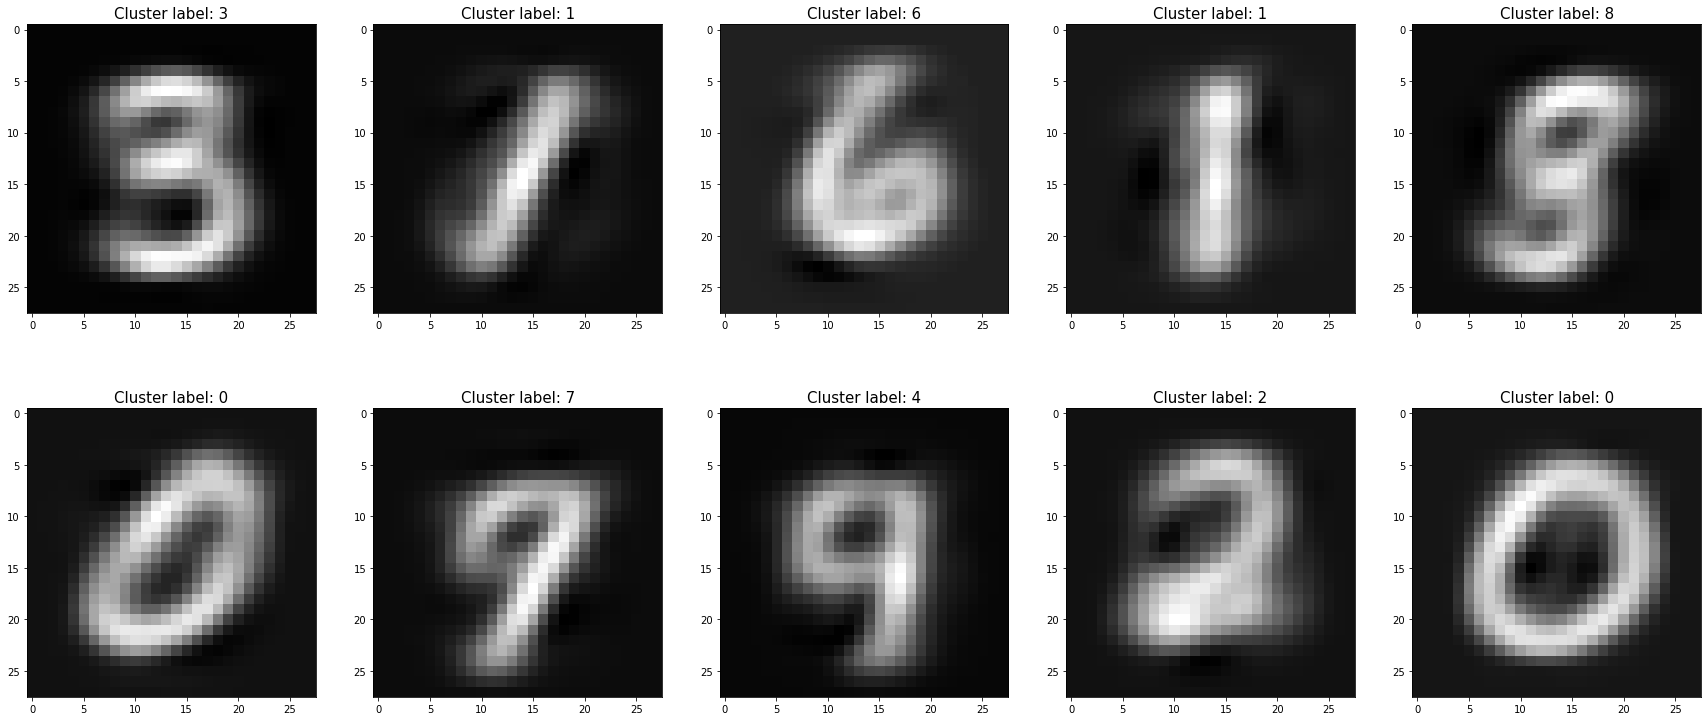

Model prediction success rate: 58.12% with p = 12


In [12]:
_, reduced_data_12, u_tp_12 = pca.reduce_dimension(images, 12)
centers_12, clusters_12 = kmeans.find_clusters(reduced_data_12)
clusters_labels_12 = show_kmeans_results(centers_12, clusters_12, y_train, u_tp_12, True)
percentage_12 = test_results(x_test, y_test, centers_12, clusters_labels_12, u_tp_12)
print(f"Model prediction success rate: {percentage_12:.2f}% with p = 12")

## section i
##### last experiment with chosen starting centers

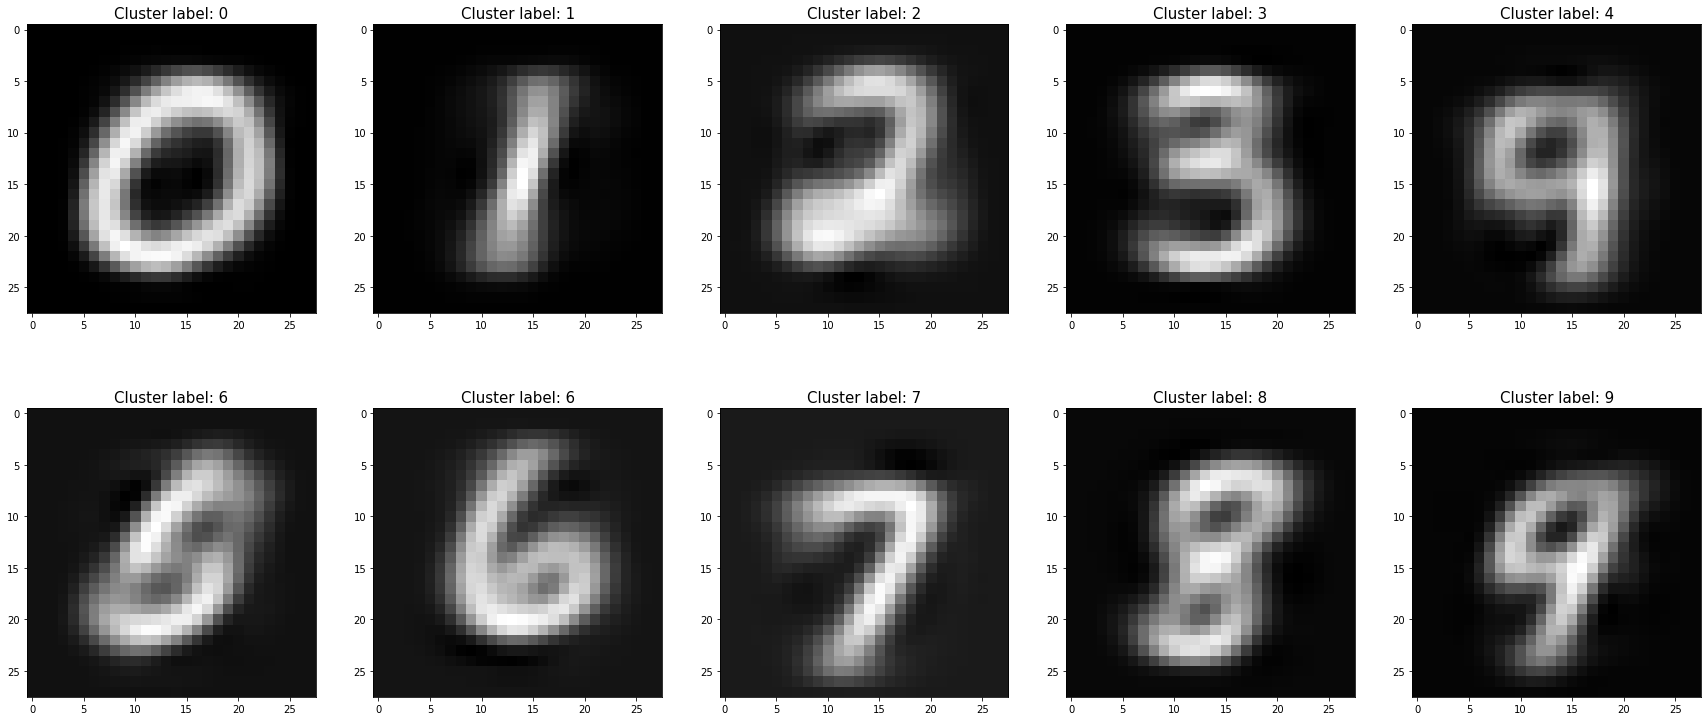

Model prediction success rate: 62.77% with chosen centers


In [13]:
def check_full(n, hist):
    return len(hist[n]) == 10

def check_full_all(hist):
    full = True
    for n in range(10):
        if not check_full(n, hist):
            full = False
            break
    return full

def choose_centers(data, labels):
    # picking 10 images from each label
    hist = [[] for _ in range(10)]
    for img_idx in range(10000):
        label = labels[img_idx]
        if check_full(label, hist):
            if check_full_all(hist):
                break
            else:
                continue
        else:
            hist[label].append(img_idx)
    l = []
    for group in hist:
        d = data[:, group].T
        mean = np.mean(d, axis=0)
        l.append(mean)
    # l = np.asarray([np.mean(data[:, group], axis=0) for group in hist])
    return l

centers, clusters = kmeans.find_clusters(reduced_data, choose_centers(reduced_data, y_train))
clusters_labels = show_kmeans_results(centers, clusters, y_train, u_tp, True)
percentage = test_results(x_test, y_test, centers, clusters_labels, u_tp)
print(f"Model prediction success rate: {percentage:.2f}% with chosen centers")